# Heart Attacks are Funny

This is some analysis to save Rich Evans' life

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import tree

## Read in the data

In [2]:
heart_df = pd.read_csv('heart.csv')

## Show me that sweet data

In [3]:
heart_df.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Features

1. age - age in years
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exng - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal - 2 = normal; 1 = fixed defect; 3 = reversable defect
14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

Looks like the previous sample had a lot of people who are gonna die. Let's see some live Rich Evans

In [4]:
good_hearts = heart_df.where(heart_df['output'] == 0).dropna()
good_hearts.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
165,67.0,1.0,0.0,160.0,286.0,0.0,0.0,108.0,1.0,1.5,1.0,3.0,2.0,0.0
166,67.0,1.0,0.0,120.0,229.0,0.0,0.0,129.0,1.0,2.6,1.0,2.0,3.0,0.0
167,62.0,0.0,0.0,140.0,268.0,0.0,0.0,160.0,0.0,3.6,0.0,2.0,2.0,0.0
168,63.0,1.0,0.0,130.0,254.0,0.0,0.0,147.0,0.0,1.4,1.0,1.0,3.0,0.0
169,53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,0.0


## Analysis

You usually start with some exploration right? Let's do some feature selection. Inspired by [this blog](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)

In [5]:
X = heart_df.drop('output', axis=1)   #Feature Matrix
y = heart_df['output']          #Target Variable

### Pearson Correlation

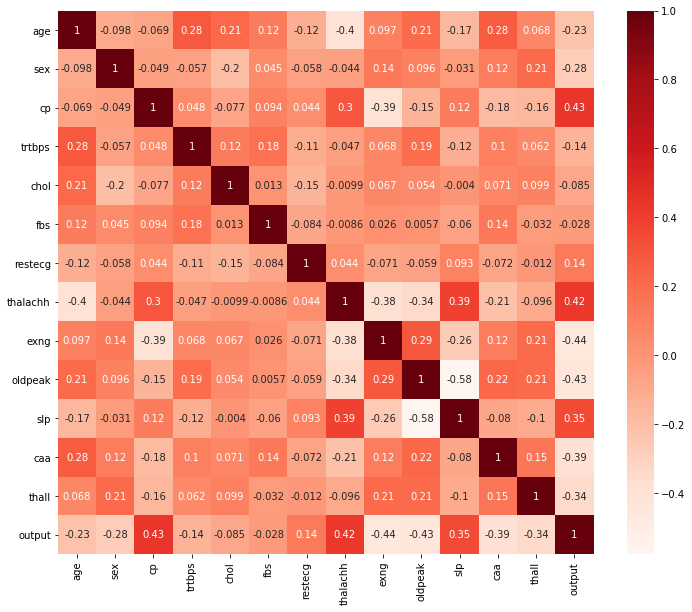

In [6]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = heart_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
#Correlation with output variable
cor_target = abs(cor['output'])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

cp          0.433798
thalachh    0.421741
exng        0.436757
oldpeak     0.430696
output      1.000000
Name: output, dtype: float64

## Initial thoughts

Chest pain, max heart rate, angia from exercise, and ST depression all mean Rich is gonna die. Makes sense. We better hope he don't got none of that.

One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest. So let us check the correlation of selected features with each other. This can be done either by visually checking it from the above correlation matrix or from the code snippet below

In [8]:
print(heart_df[["cp","thalachh"]].corr())
print(heart_df[["cp","exng"]].corr())
print(heart_df[["cp","oldpeak"]].corr())
print(heart_df[["exng","thalachh"]].corr())
print(heart_df[["exng","oldpeak"]].corr())
print(heart_df[["thalachh","oldpeak"]].corr())

                cp  thalachh
cp        1.000000  0.295762
thalachh  0.295762  1.000000
           cp     exng
cp    1.00000 -0.39428
exng -0.39428  1.00000
              cp  oldpeak
cp       1.00000 -0.14923
oldpeak -0.14923  1.00000
              exng  thalachh
exng      1.000000 -0.378812
thalachh -0.378812  1.000000
             exng   oldpeak
exng     1.000000  0.288223
oldpeak  0.288223  1.000000
          thalachh   oldpeak
thalachh  1.000000 -0.344187
oldpeak  -0.344187  1.000000


There are no correlations above 0.5 so we will keep all the features.

### Backward Elimination

Using a simple model (Ordinary Least Squares), feed all features to model. Then iteratively remove worst feature until we reach the desired performance to feature ratio. We will use a features p-value to determine whether it will save Mr. Evans' life.

In [9]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)

#Fitting sm.OLS model
model = sm.OLS(y, X_1).fit()
model.pvalues

const       4.986501e-03
age         7.611292e-01
sex         4.244938e-05
cp          8.401461e-07
trtbps      1.144073e-01
chol        4.025451e-01
fbs         7.711245e-01
restecg     2.128192e-01
thalachh    7.988188e-03
exng        5.386779e-03
oldpeak     1.084749e-02
slp         6.345322e-02
caa         6.248649e-06
thall       9.523132e-04
dtype: float64

A lower p-value means more statistical significance, so we remove the features with p-value > 0.05.

Now we loop training the model, checking the max p-value, and removing it until there are no features with p-value < 0.5

In [10]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while(len(cols) > 0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['sex', 'cp', 'thalachh', 'exng', 'oldpeak', 'caa', 'thall']


Notice sex is in this feature set while not in the feature set which was selected via Pearson Correlation. It is possible that looking at the correlations of all features at once and selecting may give a worse candidate set of features versus knowing the right subset. This 

### RFE

A more sophisticated feature elimination algorithm is the Recursive Feature Elimination (RFE) method which works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [11]:
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 7)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)

#Fitting the data to model
model.fit(X_rfe,y)

print(rfe.support_)
print(rfe.ranking_)

[False  True  True False False False False False  True  True  True  True
  True]
[6 1 1 5 7 4 2 3 1 1 1 1 1]


/home/marklar/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [12]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 11
Score with 11 features: 0.435197


/home/marklar/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/marklar/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/marklar/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/marklar/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: Futu

The RFE is the most liberal of all the feature selection algorithms so far. It found the best performance using linear regression on a subset of features selected based on the number of features desired was with 11/13 features. Now let's fit the regression model with the number of features suggested and find out which features were selected.

In [13]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 10)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)

#Fitting the data to model
model.fit(X_rfe,y)              
was_selected_array = pd.Series(rfe.support_, index = cols)
selected_features_rfe = was_selected_array[was_selected_array==True].index
print(selected_features_rfe)

Index(['sex', 'cp', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp',
       'caa', 'thall'],
      dtype='object')


/home/marklar/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### Embedded Methods

This group of algorithms uses regularization methods to select features during training. We'll try with the Ridge regularization.

In [14]:
reg = RidgeCV()
reg.fit(X, y)
print("Best alpha using built-in RidgeCV: %f" % reg.alpha_)
print("Best score using built-in RidgeCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in RidgeCV: 10.000000
Best score using built-in RidgeCV: 0.516540


In [15]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 13 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Feature importance using Ridge Model')

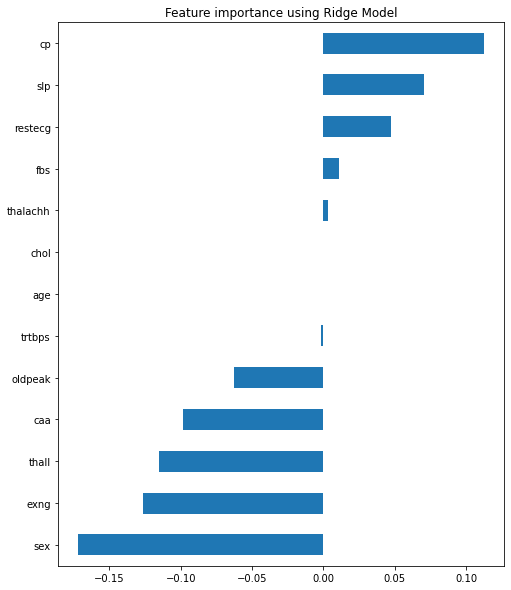

In [16]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")

Well children, we regularized Rich Evans' heart. We done good.

## Classification

Now that we have explored multiple ways to select features, let's do classification with each of the selections.

First we split the data for validation.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=19)

We are going to use a decision tree to begin because it's simple and easy to interpret.

In [18]:
dt_clf = tree.DecisionTreeClassifier()
dt_model = dt_clf.fit(X_train, y_train)

[Text(253.1925, 513.4, 'X[9] <= 0.85\ngini = 0.492\nsamples = 203\nvalue = [89, 114]'),
 Text(125.55, 453.0, 'X[12] <= 2.5\ngini = 0.306\nsamples = 106\nvalue = [20, 86]'),
 Text(61.38, 392.6, 'X[11] <= 0.5\ngini = 0.21\nsamples = 84\nvalue = [10, 74]'),
 Text(22.32, 332.2, 'X[0] <= 60.5\ngini = 0.067\nsamples = 58\nvalue = [2, 56]'),
 Text(11.16, 271.8, 'gini = 0.0\nsamples = 51\nvalue = [0, 51]'),
 Text(33.480000000000004, 271.8, 'X[0] <= 63.5\ngini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(22.32, 211.39999999999998, 'X[10] <= 1.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(11.16, 151.0, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(33.480000000000004, 151.0, 'X[3] <= 127.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(22.32, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(44.64, 90.59999999999997, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(44.64, 211.39999999999998, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(100.44, 332.2, 'X[7]

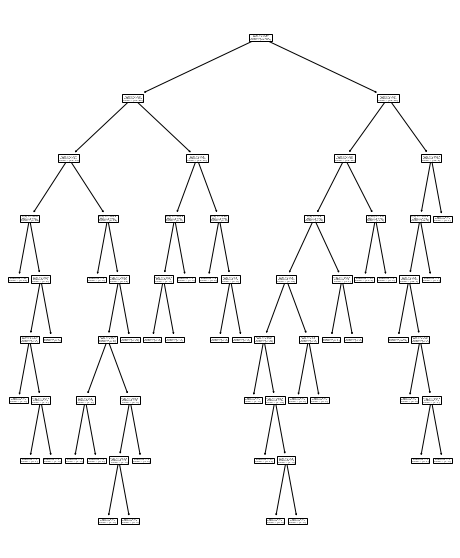

In [19]:
tree.plot_tree(dt_model)

In [20]:
import graphviz

dot_data = tree.export_graphviz(dt_model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

In [21]:
dt_clf.score(X_test, y_test)

0.69

69%, sick. That's some Rich Evans.

Now let's try remaking the decision tree but with only the features selected from Backward Elimination.

In [25]:
X_subset = X[['sex', 'cp', 'thalachh', 'exng', 'oldpeak', 'caa', 'thall']]

Index(['sex', 'cp', 'thalachh', 'exng', 'oldpeak', 'caa', 'thall'], dtype='object')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.33, random_state=19)

In [28]:
dt_clf = tree.DecisionTreeClassifier()
dt_model = dt_clf.fit(X_train, y_train)

[Text(258.61153846153843, 520.95, 'X[4] <= 0.85\ngini = 0.492\nsamples = 203\nvalue = [89, 114]'),
 Text(138.42692307692306, 475.65000000000003, 'X[6] <= 2.5\ngini = 0.306\nsamples = 106\nvalue = [20, 86]'),
 Text(62.238461538461536, 430.35, 'X[5] <= 0.5\ngini = 0.21\nsamples = 84\nvalue = [10, 74]'),
 Text(34.33846153846154, 385.05, 'X[2] <= 137.0\ngini = 0.067\nsamples = 58\nvalue = [2, 56]'),
 Text(17.16923076923077, 339.75, 'X[2] <= 134.0\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(8.584615384615384, 294.45, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(25.753846153846155, 294.45, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(51.50769230769231, 339.75, 'X[1] <= 0.5\ngini = 0.037\nsamples = 53\nvalue = [1, 52]'),
 Text(42.92307692307692, 294.45, 'X[2] <= 166.0\ngini = 0.117\nsamples = 16\nvalue = [1, 15]'),
 Text(34.33846153846154, 249.14999999999998, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(51.50769230769231, 249.14999999999998, 'X[2] <= 173.5\ngini = 0.27

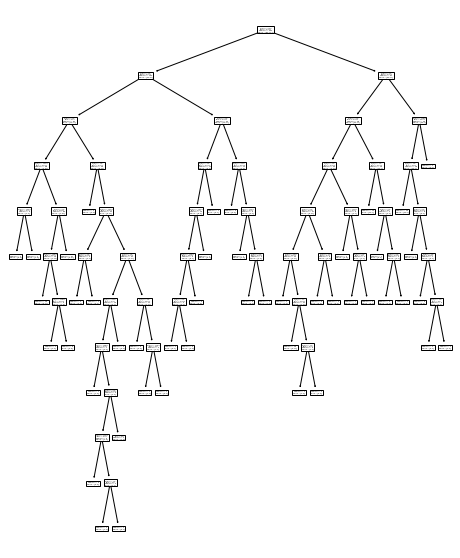

In [29]:
tree.plot_tree(dt_model)

The tree is different now. It seems that some of the subtrees go much deeper than with the superset of features.

In [30]:
dt_clf.score(X_test, y_test)

0.72

Ah ha! By using only the features suggested by our elimination algorithm, we have improved our score on the test set by 3%. Now we can really save Dick The Birthday Boy.